# T/S Diagram from ECCO

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.23.42:33587")
client

Client Scheduler: tcp://10.32.23.42:33587 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

In [11]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [12]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g', 'k', 'k_u', 'k_l', 'k_p1'])

In [13]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ETAN       (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    ETAN_snp   (time_snp, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    GEOFLX     (j, i) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    SALT       (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SALT_snp   (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    SFLUX      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    TFLUX      (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    THETA      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    THETA_snp  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    WVELMASS   (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    oceFWflx   (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceQsw     (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceSPtnd   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    ADVx_TH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_SLT   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_SLT   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    DFxE_TH    (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    DFyE_TH    (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>
    UVELMASS   (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    VVELMASS   (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 1, 90), meta=np.ndarray>

In [16]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [17]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [18]:
salt = ds.SALT.isel(**lat_range, **lon_range).mean(dim='time')
temp = ds.THETA.isel(**lat_range, **lon_range).mean(dim='time')

In [21]:
float(salt.min())

0.0

In [22]:
float(salt.max())

35.00239562988281

In [23]:
float(temp.min())

-1.9464348554611206

In [24]:
float(temp.max())

1.1922028064727783

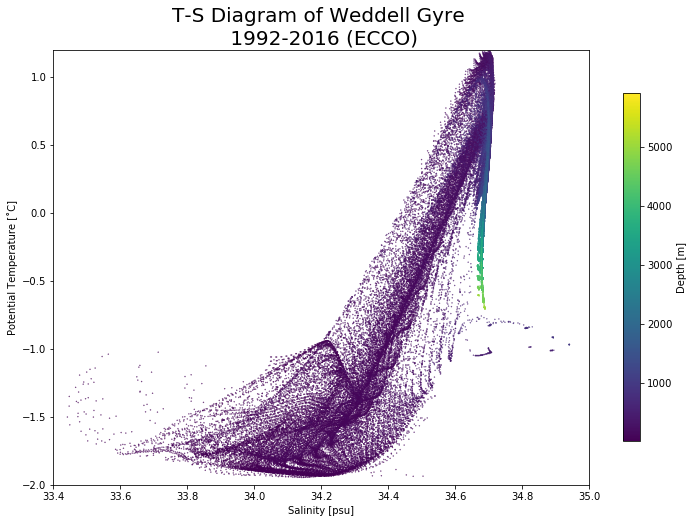

In [35]:
_, _, lev_broadcasted = xr.broadcast(salt, temp, coords.Z)

plt.figure(figsize=(12,8))
scat = plt.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)
plt.colorbar(scat, label='Depth [m]', shrink=0.8)

plt.xlim(33.4, 35)
plt.ylim(-2, 1.2)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20);

## **TRY TO PLOT EVERY TIMESTEP WITH XMOVIE**